# Week 1

[NYC taxi dataset](https://www1.nyc.gov/site/tlc/about/tlc-trip-record-data.page) "For-Hire Vehicle Trip Records" for January (Train) and February (Validation) 2021.

In [1]:
from typing import Tuple, Optional
import tempfile
import hashlib
from pathlib import Path
import os
import requests

def fetch(url: str, force: bool = False) -> bytes:
    cached = Path(tempfile.gettempdir(),
                  hashlib.md5(url.encode("utf-8")).hexdigest())
    has_cached = cached.is_file() and os.stat(cached).st_size > 0
    is_download_required = force or not has_cached
    if is_download_required:
        print("Fetching", url)
        response = requests.get(url)
        response.raise_for_status()
        data = response.content

        temp = cached.with_suffix(".tmp")
        with open(temp, "wb") as fh:
            fh.write(data)
        temp.replace(cached)
    else:
        print("Using cached", url, "data")
        with open(cached, "rb") as fh:
            data = fh.read()
    return data


Fetching data

In [2]:
january_data = fetch("https://nyc-tlc.s3.amazonaws.com/trip+data/fhv_tripdata_2021-01.parquet")
february_data = fetch("https://nyc-tlc.s3.amazonaws.com/trip+data/fhv_tripdata_2021-02.parquet")

Using cached https://nyc-tlc.s3.amazonaws.com/trip+data/fhv_tripdata_2021-01.parquet data
Using cached https://nyc-tlc.s3.amazonaws.com/trip+data/fhv_tripdata_2021-02.parquet data


In [3]:
import pandas as pd
import io

pd.set_option("float_format", "{:5f}".format)

def load_data_from_bytes(name: str, dataframe_bytes: bytes) -> pd.DataFrame:
    df = pd.read_parquet(io.BytesIO(dataframe_bytes))
    df.name = name
    print("=====", df.name, "=====")
    print("Shape:", df.shape)
    print("Columns:", df.columns)

    df["duration_in_min"] = (df.dropOff_datetime - df.pickup_datetime).apply(
        lambda diff: diff.total_seconds() / 60.
    )
    print("=====", df.name, "duration stats =====")
    print(df.duration_in_min.describe(
        percentiles=(0.01, 0.05, 0.25, 0.5, 0.75, 0.95, 0.99)
    ))
    return df


january_df = load_data_from_bytes("January", january_data)
february_df = load_data_from_bytes("February", february_data)

===== January =====
Shape: (1154112, 7)
Columns: Index(['dispatching_base_num', 'pickup_datetime', 'dropOff_datetime',
       'PUlocationID', 'DOlocationID', 'SR_Flag', 'Affiliated_base_number'],
      dtype='object')
===== January duration stats =====
count   1154112.000000
mean         19.167224
std         398.692165
min           0.016667
1%            0.416667
5%            3.016667
25%           7.766667
50%          13.400000
75%          22.283333
95%          47.250000
99%          90.300000
max      423371.050000
Name: duration_in_min, dtype: float64
===== February =====
Shape: (1037692, 7)
Columns: Index(['dispatching_base_num', 'pickup_datetime', 'dropOff_datetime',
       'PUlocationID', 'DOlocationID', 'SR_Flag', 'Affiliated_base_number'],
      dtype='object')
===== February duration stats =====
count   1037692.000000
mean         20.706986
std         161.108374
min           0.016667
1%            0.716667
5%            3.033333
25%           8.000000
50%          14.1

Removing outliers with duration outside of the (1, 60) minutes range

In [4]:
def preprocess(df: pd.DataFrame) -> pd.DataFrame:
    mask = (df.duration_in_min >= 1) & (df.duration_in_min <= 60)
    outliers_count = df.shape[0] - mask.sum(axis=0)
    print(df.name, "duration outliers count:", outliers_count)
    name = df.name
    df = df[mask].copy()
    df.name = name
    print(df.duration_in_min.describe())
    locations = ["PUlocationID", "DOlocationID"]
    print("NaNs percentage")
    print(df[locations].isnull().sum(axis=0) / df.shape[0])
    df.loc[:, locations] = df[locations].fillna(-1).astype(int).astype(str)
    return df

january_df_preproc = preprocess(january_df)
february_df_preproc = preprocess(february_df)

January duration outliers count: 44286
count   1109826.000000
mean         16.247253
std          11.551502
min           1.000000
25%           7.850000
50%          13.233333
75%          21.466667
max          60.000000
Name: duration_in_min, dtype: float64
NaNs percentage
PUlocationID   0.835273
DOlocationID   0.133270
dtype: float64
February duration outliers count: 47579
count   990113.000000
mean        16.859266
std         11.957480
min          1.000000
25%          8.000000
50%         13.833333
75%         22.466667
max         60.000000
Name: duration_in_min, dtype: float64
NaNs percentage
PUlocationID   0.857135
DOlocationID   0.136106
dtype: float64


# Training

In [5]:
import numpy as np
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import seaborn as sns
import matplotlib.pyplot as plt
from functools import partial

RMSE = partial(mean_squared_error, squared=False)


In [9]:
def extract_features(df: pd.DataFrame,
                     cat_transformer: Optional[DictVectorizer] = None) \
        -> Tuple[np.array, np.array, DictVectorizer]:
    print(df.name)
    print(df.duration_in_min.describe())
    categorical_features = ["PUlocationID", "DOlocationID"]
    cat_features_dict = df[categorical_features].to_dict(orient="records")
    if cat_transformer is None:
        cat_transformer = DictVectorizer()
        features = cat_transformer.fit_transform(cat_features_dict)
        print("Number of rows in one-hot encoding matrix",
              len(cat_transformer.get_feature_names_out()))
    else:
        features = cat_transformer.transform(cat_features_dict)
    values = df["duration_in_min"].values
    return features, values, cat_transformer


def evaluate_model(model, metrics: dict, features, values) -> dict:
    predicted_values = model.predict(features)
    metrics_values = {}
    for metric_name, metric_fn in metrics.items():
        metric_val = metric_fn(values, predicted_values)
        print(metric_name, ":", metric_val)
        metrics_values[metric_name] = metric_val 
    sns.histplot([predicted_values, values], kde=True, legend='full')
    plt.legend(["predicted", "gt"])
    plt.show()
    return metrics_values


def train(train_df: pd.DataFrame, test_df: pd.DataFrame, metrics: dict,
          model_type: type, *model_args, **model_kwargs):
    print("Extracting features...")
    train_features, train_values, cat_transformer = extract_features(train_df)
    test_features, test_values, _ = extract_features(test_df, cat_transformer)
    print("Training model type:", model_type)

    model = model_type(*model_args, **model_kwargs)
    model.fit(train_features, train_values)
    print("Train metrics")
    train_metrics = evaluate_model(model, metrics, train_features, train_values)
    
    print("Test metrics")
    test_metrics = evaluate_model(model, metrics, test_features, test_values)

    return model, train_metrics, test_metrics, cat_transformer

Extracting features...
January
count   1109826.000000
mean         16.247253
std          11.551502
min           1.000000
25%           7.850000
50%          13.233333
75%          21.466667
max          60.000000
Name: duration_in_min, dtype: float64
Number of rows in one-hot encoding matrix 525
February
count   990113.000000
mean        16.859266
std         11.957480
min          1.000000
25%          8.000000
50%         13.833333
75%         22.466667
max         60.000000
Name: duration_in_min, dtype: float64
Training model type: <class 'sklearn.linear_model._base.LinearRegression'>
Train metrics
RMSE : 10.528519463473573


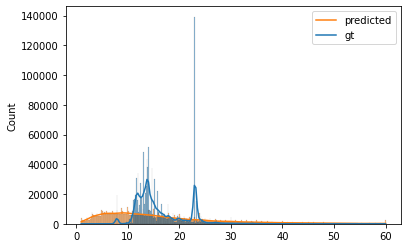

Test metrics
RMSE : 11.014288298130957


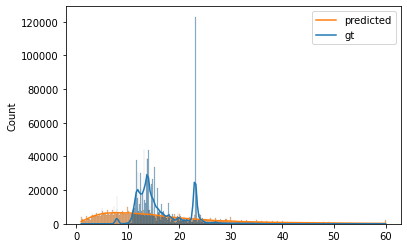

In [10]:
metrics = {
    "RMSE": RMSE
}
model, train_metric, test_metrics, _ = train(january_df_preproc, february_df_preproc,
                                             metrics, LinearRegression)
